In [1]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import wilcoxon 
from Bio.PDB import *
import os

from pylab import rcParams
from scipy.stats import chi2_contingency

# modules and functions

def is_float(elem):
    try:
        elem = float(elem)
        out = True
    except:
        elem = elem
        out = False
    return out
    

def calc_U(one, two):
    try:
        scipy_U = sp.stats.mannwhitneyu(one, two, alternative="two-sided", use_continuity=False)
        # Formula for the relation between AUC and the U statistic
        AUC = scipy_U.statistic/ (len(one)*len(two))
        pval = scipy_U.pvalue
        if AUC < 0.5:
            AUC = 1-AUC
            
        return round(AUC,3), pval
    except:
        return [np.nan, np.nan]

colormap = {'A':'#B8321A', 'C':'#44781E',
            'Compensator':"#4F651D", 'ExplicitControl':"#2F638F", 'Background':"#E5BF86",
           'GeneralControl':"#565052",'Wonder':"#C582B2", 'no_type':"#E5BF86",
           'Not compensated':'#2F414B','Compensated':'#AD6B17',
           'Not compensator':'#7C6C65',
           'Surface':"#DD3C51", 'Core':"#313657", 'PPI':"#1F6683", 
           
           'Protein interaction':"#1F6683", 
           'ligand interaction':'#B09B37',
           'Non-universal':'#B09B37',
           'Universal':"#DD3C51"}




three2one = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}





def plot_hist(hue_list, data, col_hue, col_data, mode,figsize):
    # hue_list - list with hues (different hists)
    # data - name of df
    # col_hue - name of column where separate by hue
    # col_data - name of column, where to find data
    # mode - 'wilcoxon' (paired) or 'mann' (independent) samples , 'no' - without p-val
    
    text = []
    plt.figure(figsize=figsize)
    
    for elem in hue_list:
        one = data[col_data][data[col_hue] == elem]
        sns.kdeplot(x = one, label=elem, color= colormap[elem],fill=True,
                   bw_adjust = 3)
        plt.axvline(x=np.median(one), color = colormap[elem])
        text.append(elem+' N=' + str(len(one)) + ' median=' + 
                    str(round(np.nanmedian(one),2))+'\n')
    
    plt.xlabel(col_data)
        
    if mode == 'wilcoxon':
        p_val = wilcoxon(data[col_data][data[col_hue] == hue_list[0]],
                        data[col_data][data[col_hue] == hue_list[1]])[1]
        text.append('p-value: '+str(round(p_val,5)))
        
    if mode == 'mann':
        p_val = calc_U(data[col_data][data[col_hue] == hue_list[0]],
                        data[col_data][data[col_hue] == hue_list[1]])[1]
        text.append('p-value: '+"{:6.3e}".format(p_val))
        
    
    plt.title(' '.join(text))   
    plt.legend()
    return plt
    #plt.show()



def plot_hist_bar(hue_list, data, col_hue, col_data, mode,figsize,bins, fill=False):
    # hue_list - list with hues (different hists)
    # data - name of df
    # col_hue - name of column where separate by hue
    # col_data - name of column, where to find data
    # mode - 'wilcoxon' (paired) or 'mann' (independent) samples , 'no' - without p-val
    data = data[data[col_hue].isin(hue_list)]
    text = []
    plt.figure(figsize=figsize)
   
    for elem in hue_list:
        one = data[col_data][data[col_hue] == elem]
        
        plt.axvline(x=np.median(one), color = colormap[elem])
        text.append(elem+' N=' + str(len(one)) + ' median=' + 
                    str(round(np.nanmedian(one),2))+'\n')
                    
    
    sns.histplot(data = data, x=col_data, hue=col_hue, palette = colormap,
                 common_norm=False,stat="density",bins=bins,element='step',fill=fill,
                )
    
    
    
    
    plt.xlabel(col_data)
        
    if mode == 'wilcoxon':
        p_val = wilcoxon(data[col_data][data[col_hue] == hue_list[0]],
                        data[col_data][data[col_hue] == hue_list[1]])[1]
        text.append('p-value: '+str(round(p_val,5)))
        
    if mode == 'mann':
        p_val = calc_U(data[col_data][data[col_hue] == hue_list[0]],
                        data[col_data][data[col_hue] == hue_list[1]])[1]
        text.append('p-value: '+"{:6.3e}".format(p_val))
        
    
    plt.title(' '.join(text))   
    #plt.legend()
    return plt
    #plt.show()




def plot_many_hists(hue_list, data,figure_list, col_figure, mode, 
                   figsize):
    # hue_list - list with colnames for hues
    # data - name of df
    # figure_list - list of hues (for different figures)
    # col_figure - name of column where separate by figs
    # mode - 'wilcoxon' (paired) or 'mann' (independent) samples , 'no' - without p-val
    n_rows = len(figure_list)//2
    if len(figure_list)%2 != 0:
        n_rows += 1
    i = 0
    fig, axs = plt.subplots(n_rows,2,figsize=figsize)
    for elem in figure_list:
        i1 = i//2
        i2 = i%2
        i+=1
        
        one = data[data[col_figure] == elem][hue_list[0]]
        two = data[data[col_figure] == elem][hue_list[1]]
        one_label = 'A' #A
        two_label = 'C' #C
        #sns.distplot(ax = axs[i1, i2], a=one, bins=10, label=one_label, hist=True,
                    # color=colormap[one_label])
        
        sns.kdeplot(ax = axs[i1, i2], x = one, label=one_label, 
                    color= colormap[one_label],fill=True, bw_adjust = 3)
        
        sns.kdeplot(ax = axs[i1, i2], x = two, label=two_label, 
                    color= colormap[two_label],fill=True, bw_adjust = 3)
        
        # Plot median
        axs[i1, i2].axvline(x=np.nanmedian(one), color = colormap[one_label])
        axs[i1, i2].axvline(x=np.nanmedian(two),color = colormap[two_label])
        one_text = one_label + ' N=' + str(len(one)) + ' median=' + str(round(np.nanmedian(one),2))
        two_text = two_label + ' N=' + str(len(two)) + ' median=' + str(round(np.nanmedian(two),2))
        
        
        if mode == 'wilcoxon':
            p_val = wilcoxon(one,two)[1]
            
        if mode == 'mann':
            p_val = calc_U(one,two)[1]
       
        
        
        axs[i1, i2].set_title(elem+'\n'+one_text + '\n' + two_text+'\n p-val '+
                             "{:6.3e}".format(p_val))
        #axs[i1, i2].set_xlabel(col_figure)
        axs[i1, i2].legend()

    fig.tight_layout(pad=3.0)
    return plt




def rename_bad(elem):
    if elem == 'Compensator':
        return 'Compensated'
    else:
        return 'Not compensated'
    
def rename_neutral(elem):
    if elem != 'Compensator':
        return 'Not compensator'
    else:
        return 'Compensator'
    

# Pic 2

In [29]:
df = pd.read_csv('Pic2_multiple.csv',sep=';')
df = df.iloc[:,:6]
df 

,Dataset,Method,PPI,Core,Surface,MiscInt
0,Caldraru_2020,FoldX,0.32,0.06,0.45,0.14
1,Caldraru_2020,Maestro,0.61,0.56,0.45,0.41
2,Pucci_2016,FoldX,0.20,0.57,0.54,0.44
3,Pucci_2016,Maestro,0.43,0.56,0.70,0.51
4,Skempi,FoldX,0.31,0.28,0.07,0.32
5,Skempi,Maestro,0.20,0.11,-0.07,-0.07
6,ProTherm (∆∆g_(kcal/mol)),FoldX,0.37,0.45,0.47,0.48
7,ProTherm (∆∆g_(kcal/mol)),Maestro,0.38,0.55,0.44,0.51
8,ProTherm (∆∆g_h2o_(kcal/mol)),FoldX,0.38,0.45,0.39,0.04
9,ProTherm (∆∆g_h2o_(kcal/mol)),Maestro,0.49,0.51,0.25,0.38


In [30]:
df = pd.melt(df, id_vars=['Dataset', 'Method'], value_vars=['PPI', 'Core','Surface', 'MiscInt'])
df = df.dropna()
df.shape

(48, 4)

In [32]:
df.head()

,Dataset,Method,variable,value
0,Caldraru_2020,FoldX,PPI,0.32
1,Caldraru_2020,Maestro,PPI,0.61
2,Pucci_2016,FoldX,PPI,0.20
3,Pucci_2016,Maestro,PPI,0.43
4,Skempi,FoldX,PPI,0.31


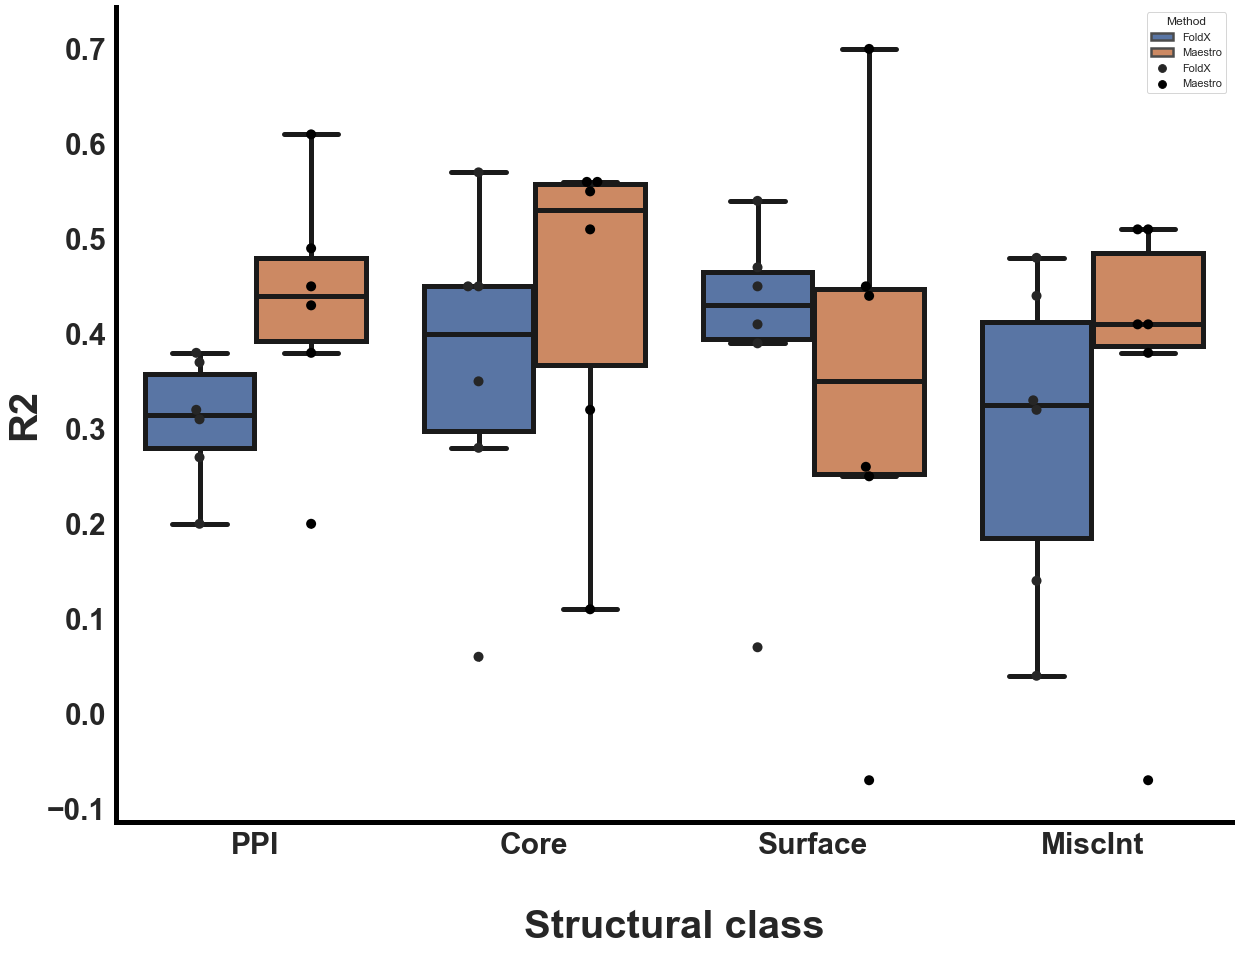

In [22]:



mpl.rcParams['axes.linewidth'] = 5 #задаем толщину линий
width,  height = 20, 15 

sns_plot = sns.boxplot(df['variable'], df['value'], hue = df['Method'],
                         linewidth=5)

sns_plot = sns.swarmplot(x=df['variable'], y=df['value'], hue = df['Method'], dodge=True,
                         color="black",   size=10)

#for violin, alpha in zip(sns_plot.collections[::2], [0.85 for i in range(4)]):
    #violin.set_alpha(alpha)
#plt.title(fig.axes[0].get_title(), loc='center', pad = 10,
         #size = 20)
    
plt.setp(sns_plot.artists, edgecolor = 'k') #ставим черный и белые цвета
plt.setp(sns_plot.lines, color='k')

sns.set(rc={"figure.figsize": (width, height)})
sns.set_style("whitegrid")#белый фон
sns_plot.grid(False)#убрать полоски
sns_plot.spines['bottom'].set_color('black')


sns_plot.spines['left'].set_color('black')
   
sns.despine()# убрать рамку

plt.ylabel('R2',size = 40, weight='extra bold') 
plt.xlabel('Structural class', size=40,  weight='extra bold', labelpad=50)
plt.xticks(size=30, weight='bold', ha="center" )
plt.yticks(size=30, weight='bold', ha="right" )
#plt.ylim((-5,20))
fig = sns_plot.get_figure()
#fig.savefig(compeletename+ 'Fig3_ddg.png', bbox_inches="tight", dpi = 100)

In [23]:
for elem in df['variable'].unique().tolist():
    df1 = df[df['variable']==elem]
    print('----')
    print(elem)
    print(calc_U(df1[df1['Method']=='FoldX']['value'],df1[df1['Method']=='Maestro']['value']))

----
PPI
(0.833, 0.053818822070227784)
----
Core
(0.639, 0.4217118075268833)
----
Surface
(0.597, 0.5745038102346656)
----
MiscInt
(0.667, 0.33497274465939986)


# Compare single multiple

In [33]:
dfsingle = pd.read_csv('Pic2_single.csv',sep=';')
dfsingle.head()

,Dataset,Method,PPI,Core,Surface,MiscInt
0,Caldraru_2020,FoldX,0.33,0.37,0.51,0.26
1,Caldraru_2020,Maestro,0.61,0.58,0.45,0.42
2,Pucci_2016,FoldX,0.42,0.58,0.54,0.45
3,Pucci_2016,Maestro,0.41,0.56,0.70,0.51
4,Skempi,FoldX,0.32,0.28,0.07,0.31


In [34]:
dfsingle = pd.melt(dfsingle, id_vars=['Dataset', 'Method'], value_vars=['PPI', 'Core','Surface', 'MiscInt'])
dfsingle = dfsingle.dropna()
dfsingle.shape

(48, 4)

In [35]:
df = pd.merge(df, dfsingle, on = ['Dataset', 'Method', 'variable'])
df = df.rename(columns = {'value_x':'multiple', 'value_y':'single'})


In [38]:
df = df.rename(columns = {'variable':'RIN'})

In [40]:
df = pd.melt(df, id_vars=['Dataset', 'Method', 'RIN'], value_vars=['multiple', 'single'])

In [42]:
df.head()

,Dataset,Method,RIN,variable,value
0,Caldraru_2020,FoldX,PPI,multiple,0.32
1,Caldraru_2020,Maestro,PPI,multiple,0.61
2,Pucci_2016,FoldX,PPI,multiple,0.20
3,Pucci_2016,Maestro,PPI,multiple,0.43
4,Skempi,FoldX,PPI,multiple,0.31


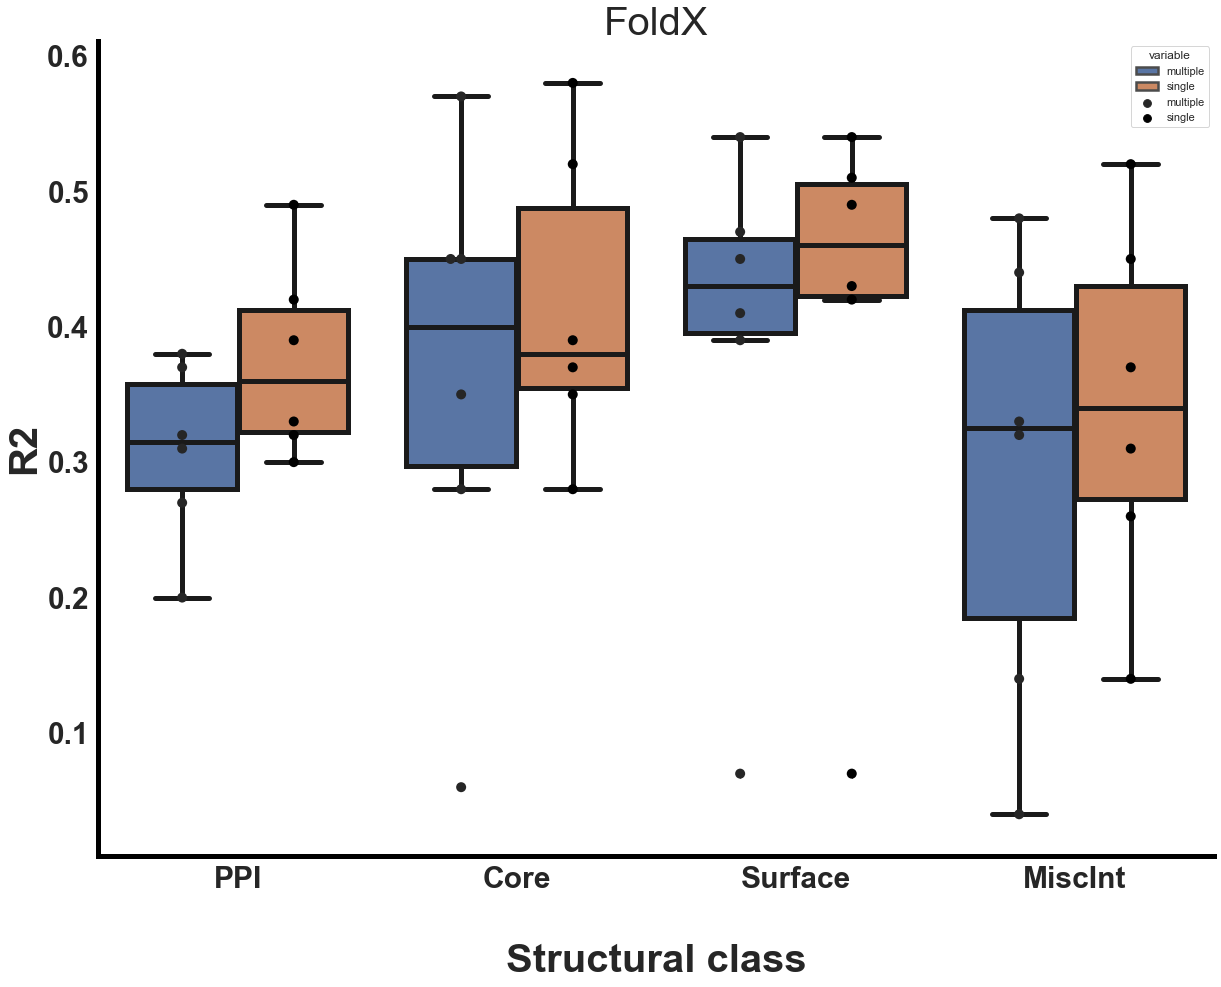

In [49]:
dffold = df[df['Method']=='FoldX']
mpl.rcParams['axes.linewidth'] = 5 #задаем толщину линий
width,  height = 20, 15 

sns_plot = sns.boxplot(dffold['RIN'], dffold['value'], hue = dffold['variable'],
                         linewidth=5)

sns_plot = sns.swarmplot(x=dffold['RIN'], y=dffold['value'], hue = dffold['variable'], dodge=True,
                         color="black",   size=10)

#for violin, alpha in zip(sns_plot.collections[::2], [0.85 for i in range(4)]):
    #violin.set_alpha(alpha)
#plt.title(fig.axes[0].get_title(), loc='center', pad = 10,
         #size = 20)
    
plt.setp(sns_plot.artists, edgecolor = 'k') #ставим черный и белые цвета
plt.setp(sns_plot.lines, color='k')

sns.set(rc={"figure.figsize": (width, height)})
sns.set_style("whitegrid")#белый фон
sns_plot.grid(False)#убрать полоски
sns_plot.spines['bottom'].set_color('black')


sns_plot.spines['left'].set_color('black')
   
sns.despine()# убрать рамку

plt.ylabel('R2',size = 40, weight='extra bold') 
plt.xlabel('Structural class', size=40,  weight='extra bold', labelpad=50)
plt.xticks(size=30, weight='bold', ha="center" )
plt.yticks(size=30, weight='bold', ha="right" )
plt.title('FoldX', size=40, )
#plt.ylim((-5,20))
fig = sns_plot.get_figure()
#fig.savefig(compeletename+ 'Fig3_ddg.png', bbox_inches="tight", dpi = 100)

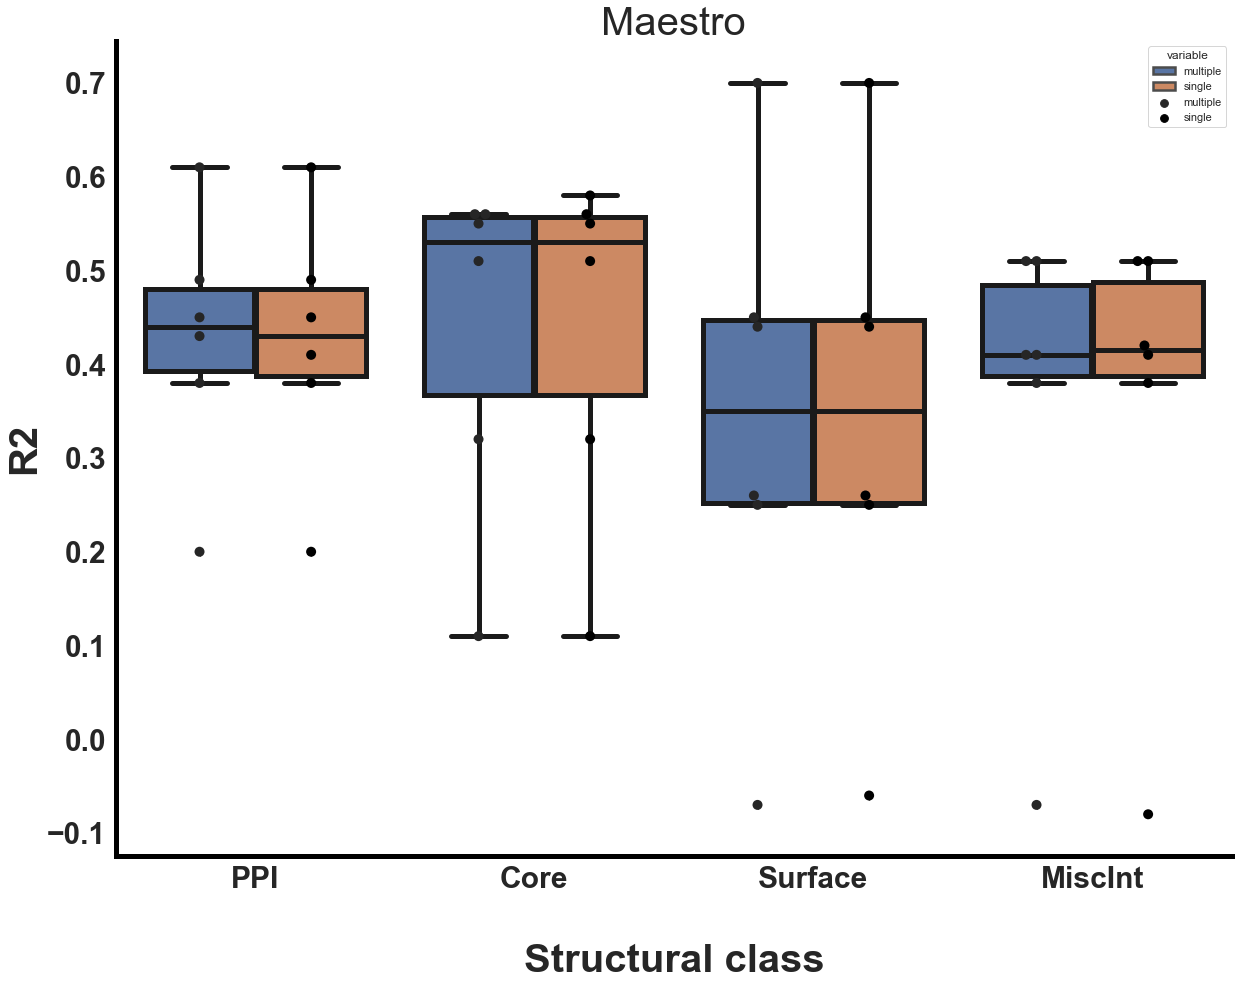

In [47]:
dffold = df[df['Method']=='Maestro']
mpl.rcParams['axes.linewidth'] = 5 #задаем толщину линий
width,  height = 20, 15 

sns_plot = sns.boxplot(dffold['RIN'], dffold['value'], hue = dffold['variable'],
                         linewidth=5)

sns_plot = sns.swarmplot(x=dffold['RIN'], y=dffold['value'], hue = dffold['variable'], dodge=True,
                         color="black",   size=10)

#for violin, alpha in zip(sns_plot.collections[::2], [0.85 for i in range(4)]):
    #violin.set_alpha(alpha)
#plt.title(fig.axes[0].get_title(), loc='center', pad = 10,
         #size = 20)
    
plt.setp(sns_plot.artists, edgecolor = 'k') #ставим черный и белые цвета
plt.setp(sns_plot.lines, color='k')

sns.set(rc={"figure.figsize": (width, height)})
sns.set_style("whitegrid")#белый фон
sns_plot.grid(False)#убрать полоски
sns_plot.spines['bottom'].set_color('black')


sns_plot.spines['left'].set_color('black')
   
sns.despine()# убрать рамку

plt.ylabel('R2',size = 40, weight='extra bold') 
plt.xlabel('Structural class', size=40,  weight='extra bold', labelpad=50)
plt.xticks(size=30, weight='bold', ha="center" )
plt.yticks(size=30, weight='bold', ha="right" )
plt.title('Maestro', size=40, )
#plt.ylim((-5,20))
fig = sns_plot.get_figure()
#fig.savefig(compeletename+ 'Fig3_ddg.png', bbox_inches="tight", dpi = 100)

In [11]:
df.head()

,Dataset,Method,variable,value
0,Caldraru_2020,FoldX,PPI,0.32
1,Caldraru_2020,Maestro,PPI,0.61
2,Pucci_2016,FoldX,PPI,0.20
3,Pucci_2016,Maestro,PPI,0.43
4,Skempi,FoldX,PPI,0.31


# Pic AD AR

In [50]:
df = pd.read_csv('Pic_adar.csv',sep=';',index_col=0)
for elem in df.columns.tolist():
    df[elem] = df[elem].str.replace(',', '.')
    df[elem] = df[elem].astype(float)
df

,AD_PatRel,AD_PatAll,AD_BenRel,AD_BenAll+gm,AR_PatRel,AR_PatAll,AR_BenRel,AR_BenAll+gm
Core,1.263566,1.197674,0.794574,0.852713,1.632399,1.542056,0.800623,0.691589
MiscInt,1.409524,1.695238,0.409524,0.600000,1.383721,1.534884,0.500000,0.732558
PPI,1.181481,1.181481,0.740741,0.788889,0.887805,0.921951,0.804878,1.029268
Surface,0.564033,0.528610,1.504087,1.373297,0.453608,0.476804,1.378866,1.298969


In [51]:
my_range=range(1,len(df.index)+1)

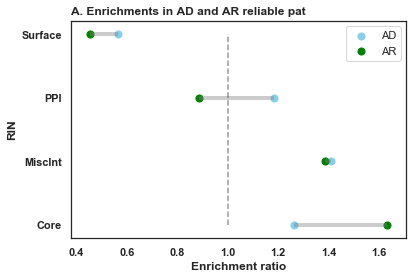

In [56]:



#mpl.rcParams['axes.linewidth'] = 5 #задаем толщину линий
width,  height = 6, 4

    



#sns_plot.grid(False)#убрать полоски
#sns_plot.spines['bottom'].set_color('black')


#sns_plot.spines['left'].set_color('black')
   
sns.despine()# убрать рамку



sns.set(rc={"figure.figsize": (width, height)})
sns.set_style("white")#белый фон
# The horizontal plot is made using the hline function
plt.hlines(y=my_range, xmin=df['AD_PatRel'], xmax=df['AR_PatRel'], color='grey', alpha=0.4,linewidths=4)
plt.scatter(df['AD_PatRel'], my_range, color='skyblue', alpha=1, label='AD', s=50)
plt.scatter(df['AR_PatRel'], my_range, color='green', alpha=1 , label='AR',s=50)
plt.legend()
 
plt.vlines(x=1, ymin=1, ymax=4, color='black', alpha=0.4,linestyles='dashed')
# Add title and axis names
plt.yticks(my_range, df.index, weight='bold')
plt.title("A. Enrichments in AD and AR reliable pat", loc='left',weight='bold')
plt.xlabel('Enrichment ratio',weight='bold')
plt.xticks(weight='bold')
plt.ylabel('RIN',weight='bold')

# Show the graph
#plt.show()
plt.savefig('fig3A', dpi=200,)

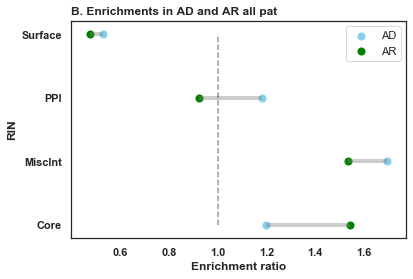

In [53]:

#mpl.rcParams['axes.linewidth'] = 5 #задаем толщину линий
width,  height = 6, 4


#sns_plot.grid(False)#убрать полоски
#sns_plot.spines['bottom'].set_color('black')


#sns_plot.spines['left'].set_color('black')
   
sns.despine()# убрать рамку



sns.set(rc={"figure.figsize": (width, height)})
sns.set_style("white")#белый фон
# The horizontal plot is made using the hline function
plt.hlines(y=my_range, xmin=df['AD_PatAll'], xmax=df['AR_PatAll'], color='grey', alpha=0.4,linewidths=4)
plt.scatter(df['AD_PatAll'], my_range, color='skyblue', alpha=1, label='AD', s=50)
plt.scatter(df['AR_PatAll'], my_range, color='green', alpha=1 , label='AR',s=50)
plt.legend()
 
plt.vlines(x=1, ymin=1, ymax=4, color='black', alpha=0.4,linestyles='dashed')
# Add title and axis names
plt.yticks(my_range, df.index, weight='bold')
plt.title("B. Enrichments in AD and AR all pat", loc='left',weight='bold')
plt.xlabel('Enrichment ratio',weight='bold')
plt.xticks(weight='bold')
plt.ylabel('RIN',weight='bold')

# Show the graph
#plt.show()
plt.savefig('fig3B', dpi=200,)

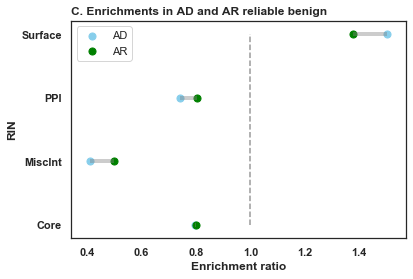

In [54]:



#mpl.rcParams['axes.linewidth'] = 5 #задаем толщину линий
width,  height = 6, 4

    



#sns_plot.grid(False)#убрать полоски
#sns_plot.spines['bottom'].set_color('black')


#sns_plot.spines['left'].set_color('black')
   
sns.despine()# убрать рамку



sns.set(rc={"figure.figsize": (width, height)})
sns.set_style("white")#белый фон
# The horizontal plot is made using the hline function
plt.hlines(y=my_range, xmin=df['AD_BenRel'], xmax=df['AR_BenRel'], color='grey', alpha=0.4,linewidths=4)
plt.scatter(df['AD_BenRel'], my_range, color='skyblue', alpha=1, label='AD', s=50)
plt.scatter(df['AR_BenRel'], my_range, color='green', alpha=1 , label='AR',s=50)
plt.legend()
 
plt.vlines(x=1, ymin=1, ymax=4, color='black', alpha=0.4,linestyles='dashed')
# Add title and axis names
plt.yticks(my_range, df.index, weight='bold')
plt.title("С. Enrichments in AD and AR reliable benign", loc='left',weight='bold')
plt.xlabel('Enrichment ratio',weight='bold')
plt.xticks(weight='bold')
plt.ylabel('RIN',weight='bold')

# Show the graph
#plt.show()
plt.savefig('fig3С', dpi=200,)

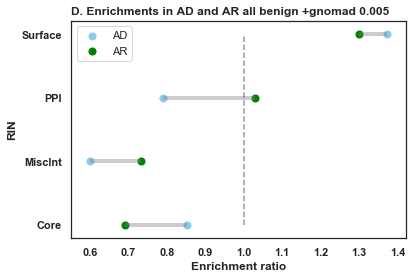

In [55]:



#mpl.rcParams['axes.linewidth'] = 5 #задаем толщину линий
width,  height = 6, 4

    



#sns_plot.grid(False)#убрать полоски
#sns_plot.spines['bottom'].set_color('black')


#sns_plot.spines['left'].set_color('black')
   
sns.despine()# убрать рамку



sns.set(rc={"figure.figsize": (width, height)})
sns.set_style("white")#белый фон
# The horizontal plot is made using the hline function
plt.hlines(y=my_range, xmin=df['AD_BenAll+gm'], xmax=df['AR_BenAll+gm'], color='grey', alpha=0.4,linewidths=4)
plt.scatter(df['AD_BenAll+gm'], my_range, color='skyblue', alpha=1, label='AD', s=50)
plt.scatter(df['AR_BenAll+gm'], my_range, color='green', alpha=1 , label='AR',s=50)
plt.legend()
 
plt.vlines(x=1, ymin=1, ymax=4, color='black', alpha=0.4,linestyles='dashed')
# Add title and axis names
plt.yticks(my_range, df.index, weight='bold')
plt.title("D. Enrichments in AD and AR all benign +gnomad 0.005", loc='left',weight='bold')
plt.xlabel('Enrichment ratio',weight='bold')
plt.xticks(weight='bold')
plt.ylabel('RIN',weight='bold')

# Show the graph
#plt.show()
plt.savefig('fig3D', dpi=200,)